# Home inference & Data Panel: Understanding & data tests

Homes were inferred for each user in the stays data with script
/infer_homes.py

This notetbook pokes through the data, finds reasonable dataframes, matches the data up to known population statistics, and shows  some interesting things to do with it.

In [3]:
import datetime
import pathlib
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


IMSI = 'imsi'
MCC = 'mcc'
PARISH = 'parish'
DAYS = 'days'
NIGHTS = 'nights'
DATAFILES = 'datafiles'

DATA_FILEPATH = '/home/data_commons/andorra_data_2020/'

PRESENCE_OTHERS_FPATH = DATA_FILEPATH+'days_present/presence_others.csv'

In [4]:
def get_homes_filepath(year, month):
    return '{}homes/{}_{}_homes.csv'.format(DATA_FILEPATH, year, month)

def get_stays_filepath(year, month, day):
    return '{}stays/{}_{}/stays_{}_{}_{}.csv'.format(DATA_FILEPATH, year, month, year, month, day)


In [5]:
# Make a dict mapping (year, month) --> homes df

months = [
    (2019,3), (2019,4), (2019,5),
    (2020,1), (2020,2), (2020,3), (2020,4), (2020,5), (2020,6),
]
months_homes_dfs =  dict()
for i, (year, month) in enumerate(months):
    print('reading homes data for %s-%s' % (year, month))
    month_df =  pd.read_csv(get_homes_filepath(year, month))
    months_homes_dfs[(year,month)] = month_df

reading homes data for 2019-3
reading homes data for 2019-4
reading homes data for 2019-5
reading homes data for 2020-1
reading homes data for 2020-2
reading homes data for 2020-3
reading homes data for 2020-4
reading homes data for 2020-5
reading homes data for 2020-6


#### Add  some more columns to help understanding data panels

##### days portion = (float) nights/datafiles
##### nights portion = (float) nights/datafiles
To make counting nights consistent 

##### Andorran  SIM
Whether the user  has an Andorran SIM (MCC)

##### Nationality
Readable nationality by SIM/MCC


In [6]:
DAYS_PORTION = 'days portion'
NIGHTS_PORTION = 'nights portion'
ANDORRAN_SIM = 'Andorran SIM'
FOREIGN_SIM =  'Foreign SIM'
NATIONALITY = 'nationality'

MCC_ANDORRA = 213
mcc_names_dict = {
    213:'Andorran',
    214:'Spanish',
    208:'French',
    234:'British',
}
def get_nationality(mcc):
    return mcc_names_dict[mcc] if mcc in mcc_names_dict else 'Other'

In [7]:
for i, (month, df) in enumerate(months_homes_dfs.items()):
    df[DAYS_PORTION] =  df[DAYS]/df[DATAFILES]
    df[NIGHTS_PORTION] =  df[NIGHTS]/df[DATAFILES]
    df[ANDORRAN_SIM] = (df[MCC]==MCC_ANDORRA)
    df[NATIONALITY] = df[MCC].apply(get_nationality) 
    months_homes_dfs[month] = df

In [8]:
df.head()

,imsi,parish,days,nights,mcc,datafiles,days portion,nights portion,Andorran SIM,nationality
0,00003033627476c3619c56dc0c3ee4753bc5d5bd08688a...,Sant Julià de Lòria,5,2,213,28,0.178571,0.071429,True,Andorran
1,000054e634b0868ae8816f7d5761b7bfb8aea6804296f2...,Andorra la Vella,22,15,213,28,0.785714,0.535714,True,Andorran
2,0000a0b3b11eb030ba63413f2e1705745464b86ba4b1a8...,Andorra la Vella,4,3,214,28,0.142857,0.107143,False,Spanish
3,0000ec008235b115def70c44ec9931ab1161ee1854e5d9...,Andorra la Vella,18,7,213,28,0.642857,0.250000,True,Andorran
4,0001ecaa520a57cf10b46a64e599ab9e0c53f855f47008...,Sant Julià de Lòria,3,3,208,28,0.107143,0.107143,False,French


## [Paper] Comparing RNC population to known population

To evaluate the inferences of home parishes, this data is compared to official population statistics from 2020.
https://www.estadistica.ad/serveiestudis/noticies/noticia5059cat.pdf

This evaluation uses data from May, 2020 and is restricted to the subscribers that the pre-processing categorizes as non-tourists (i.e. present for at least 50 days in Andorra), and further restricts this set of subscribers using Andorra as their home network. The month of May is used because it was the last month of the lockdown before the country reopened its borders.

The Pearson correlation between the parish-level populations inferred from this analysis and  the official population statistics is 0.958.

Make a dataframe from the May 2020 homes data restricted to  the non-tourists with columns:
```
imsi, parish, days, Andorran SIM
```

Compare inferred population with official stats

In [68]:
pop_stats_df = pd.DataFrame(data={
    PARISH: [
        'Andorra la Vella',
        'Escaldes-Engordany',
        'La Massana',
        'Ordino',
        'Sant Julià de Lòria',
        'Canillo',
        'Encamp'],
    'population': [
        22504,
        14626,
        10199,
        4957,
        9374,
        4371,
        11716]
}).set_index(PARISH)
o_a_may_2020_home_parish_counts = o_a_may_2020_homes_df[PARISH].value_counts()
pop_stats_df['inferred subscriber population'] = pop_stats_df.index.map(o_a_may_2020_home_parish_counts)
pop_stats_df = pop_stats_df.sort_index()
pop_stats_df

,population,inferred subscriber population
parish,,
Andorra la Vella,22504,13555
Canillo,4371,4367
Encamp,11716,6766
Escaldes-Engordany,14626,7366
La Massana,10199,6165
Ordino,4957,2427
Sant Julià de Lòria,9374,4339


In [69]:
pop_stats_df.corr()

,population,inferred subscriber population
population,1.000000,0.958879
inferred subscriber population,0.958879,1.000000


Aggregate the population counts

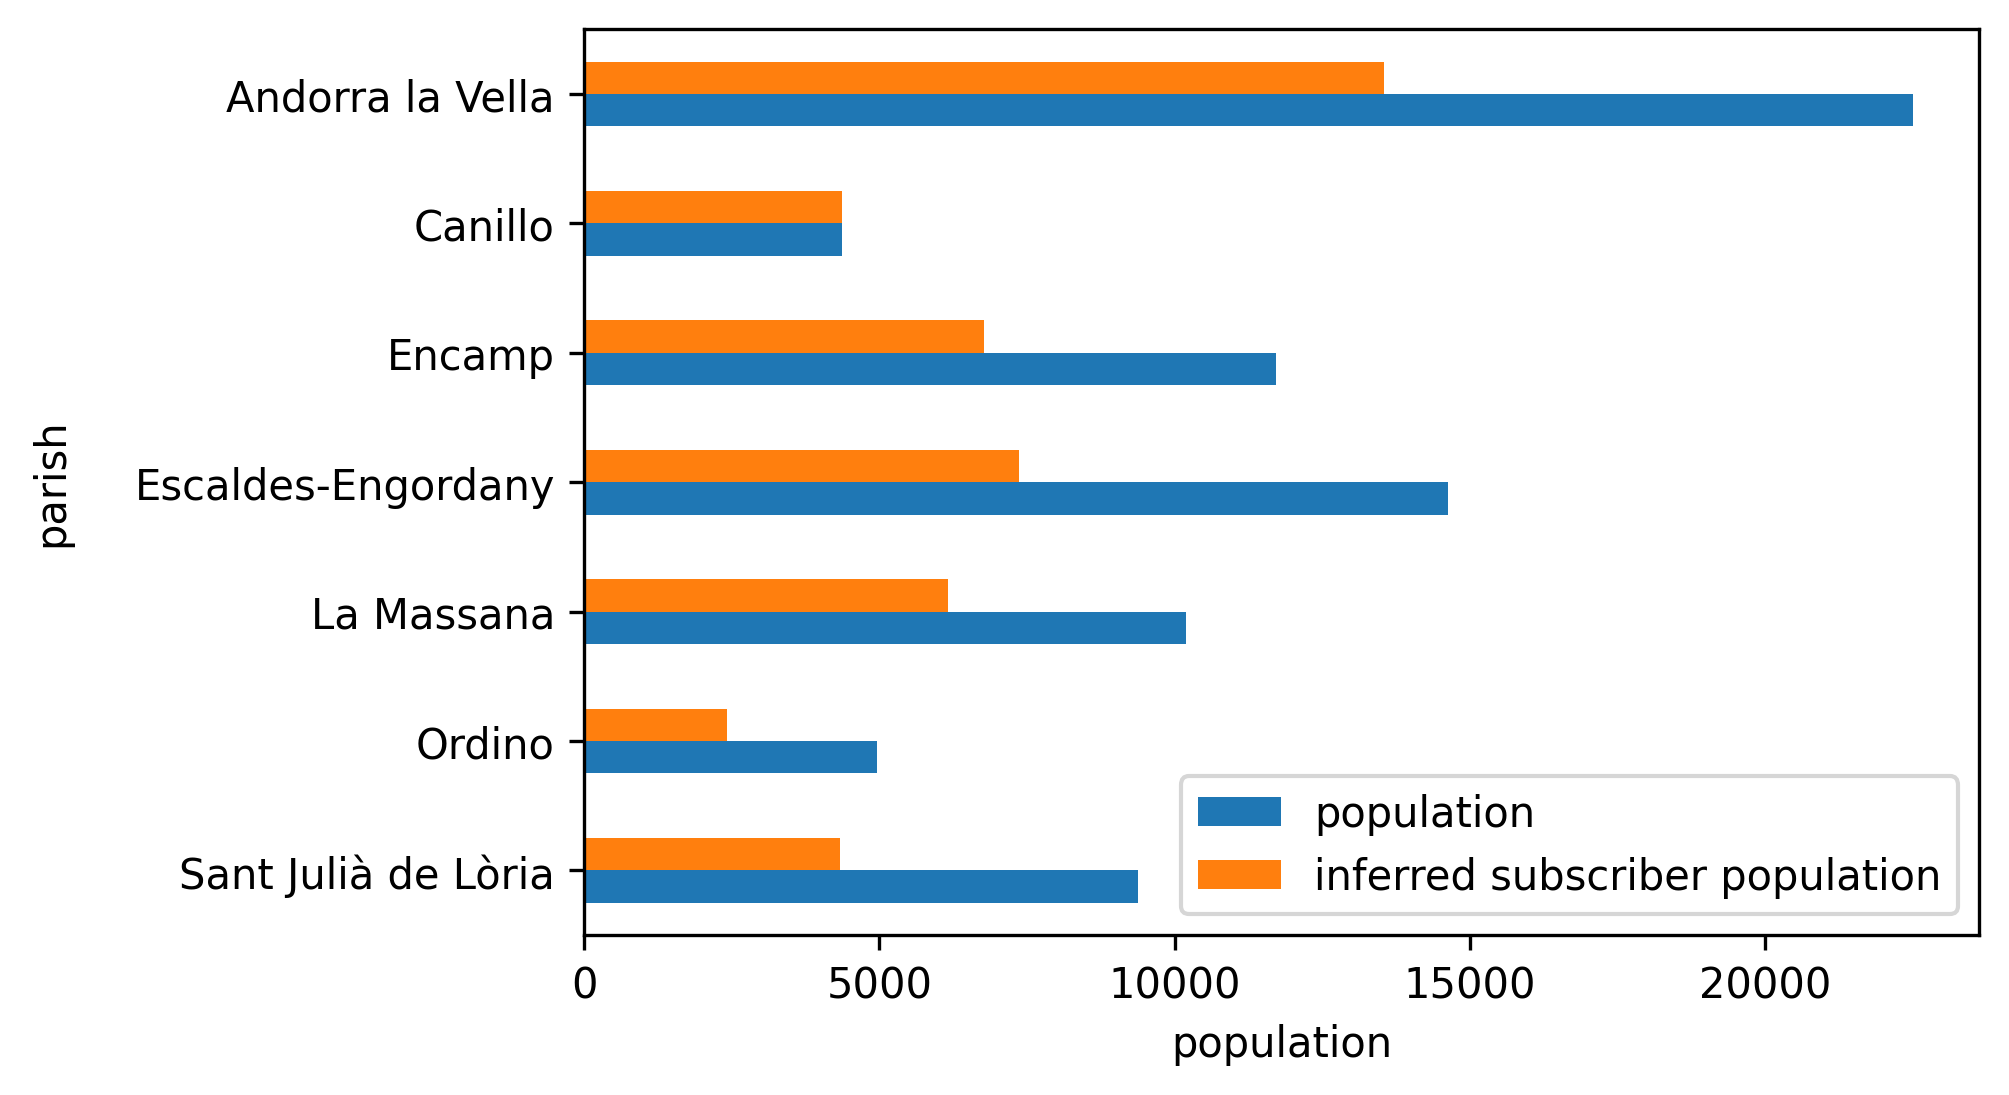

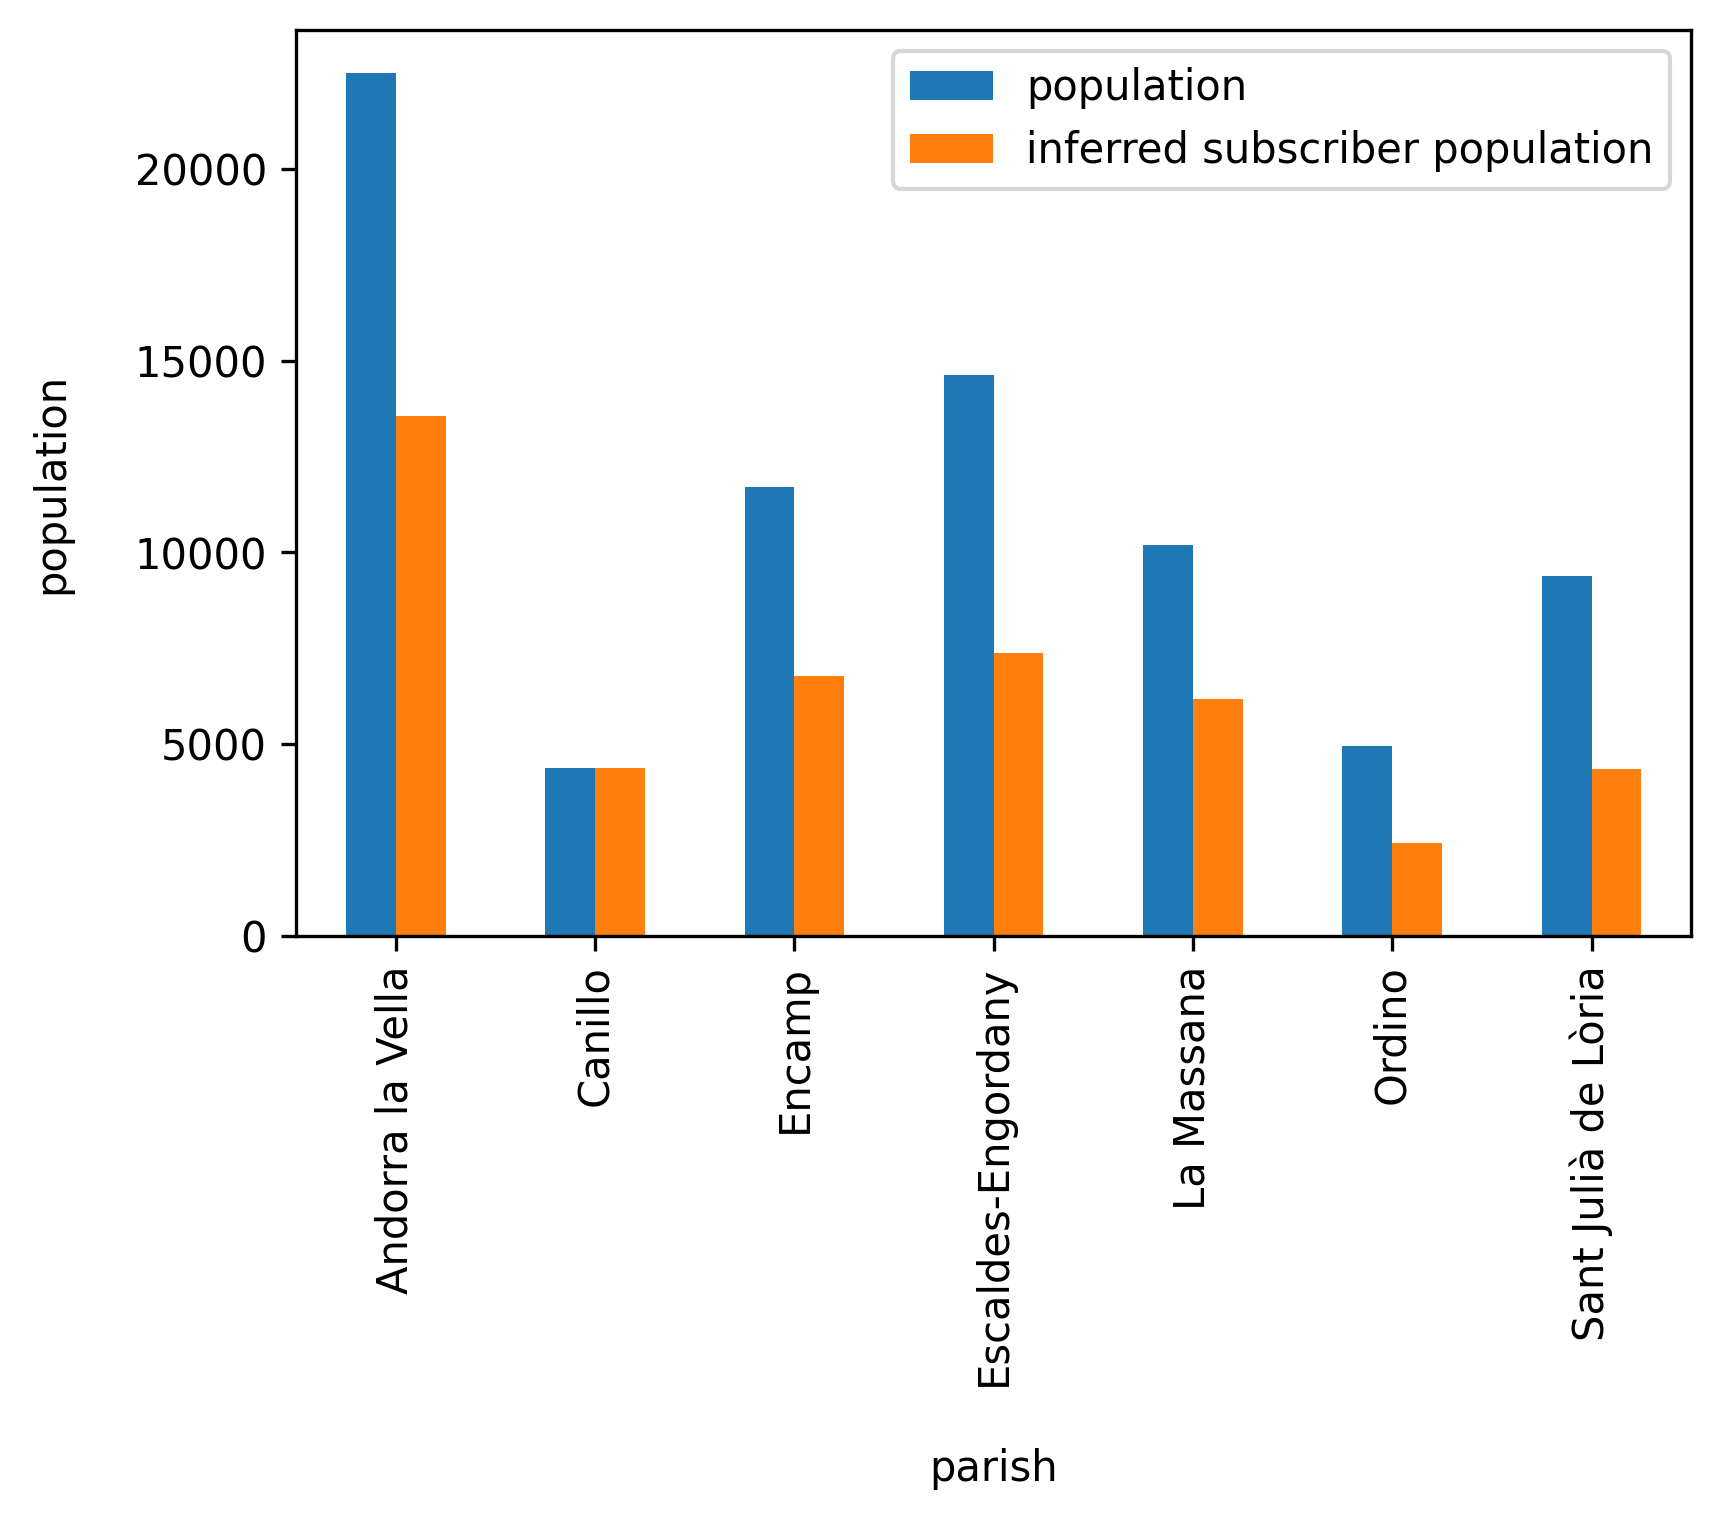

In [70]:
plt.rcParams["figure.dpi"] = 300
pop_stats_df.sort_index(ascending=False).plot.barh()
plt.xlabel('population')
plt.ylabel('parish', labelpad=15)
plt.show()
pop_stats_df.plot.bar()
plt.ylabel('population', labelpad=15)
plt.xlabel('parish', labelpad=15)
plt.show()

### Days & Nights  of  data
#### Each month, by Andorran vs Non-Andorran SIMs

What is a reasonable dataframe?
How many users have at least X  days  of data  and  Y nights of data each month?


Make some  tables and plot them for each  month

Y,M:
```
days, Andorran SIM, Foreign SIM
```
```
nights, Andorran SIM, Foreign SIM
```

where each row represents  the number of people who have  data  for at  least  that many days/nights

In [9]:
days_nights_list = list(range(1,32,3))
days_nights_list

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31]

In [10]:
month_data_days = {} # (year,month) --> df
month_data_nights = {} # (year,month) --> df

for i, (month,df) in enumerate(months_homes_dfs.items()):
    print('(%s) processing data for %s'  % (i,month))
    a_df = df[df[ANDORRAN_SIM]]
    f_df = df[~df[ANDORRAN_SIM]]
    days_df = pd.DataFrame({
        DAYS: days_nights_list,
        ANDORRAN_SIM: [len(a_df[a_df[DAYS] >= d]) for d in days_nights_list],
        FOREIGN_SIM: [len(f_df[f_df[DAYS] >= d]) for d in days_nights_list],
    }).set_index(DAYS)
    nights_df = pd.DataFrame({
        NIGHTS: days_nights_list,
        ANDORRAN_SIM: [len(a_df[a_df[NIGHTS] >= d]) for d in days_nights_list],
        FOREIGN_SIM: [len(f_df[f_df[NIGHTS] >= d]) for d in days_nights_list],
    }).set_index(NIGHTS)
    month_data_days[month] = days_df
    month_data_nights[month] = nights_df

(0) processing data for (2019, 3)
(1) processing data for (2019, 4)
(2) processing data for (2019, 5)
(3) processing data for (2020, 1)
(4) processing data for (2020, 2)
(5) processing data for (2020, 3)
(6) processing data for (2020, 4)
(7) processing data for (2020, 5)
(8) processing data for (2020, 6)


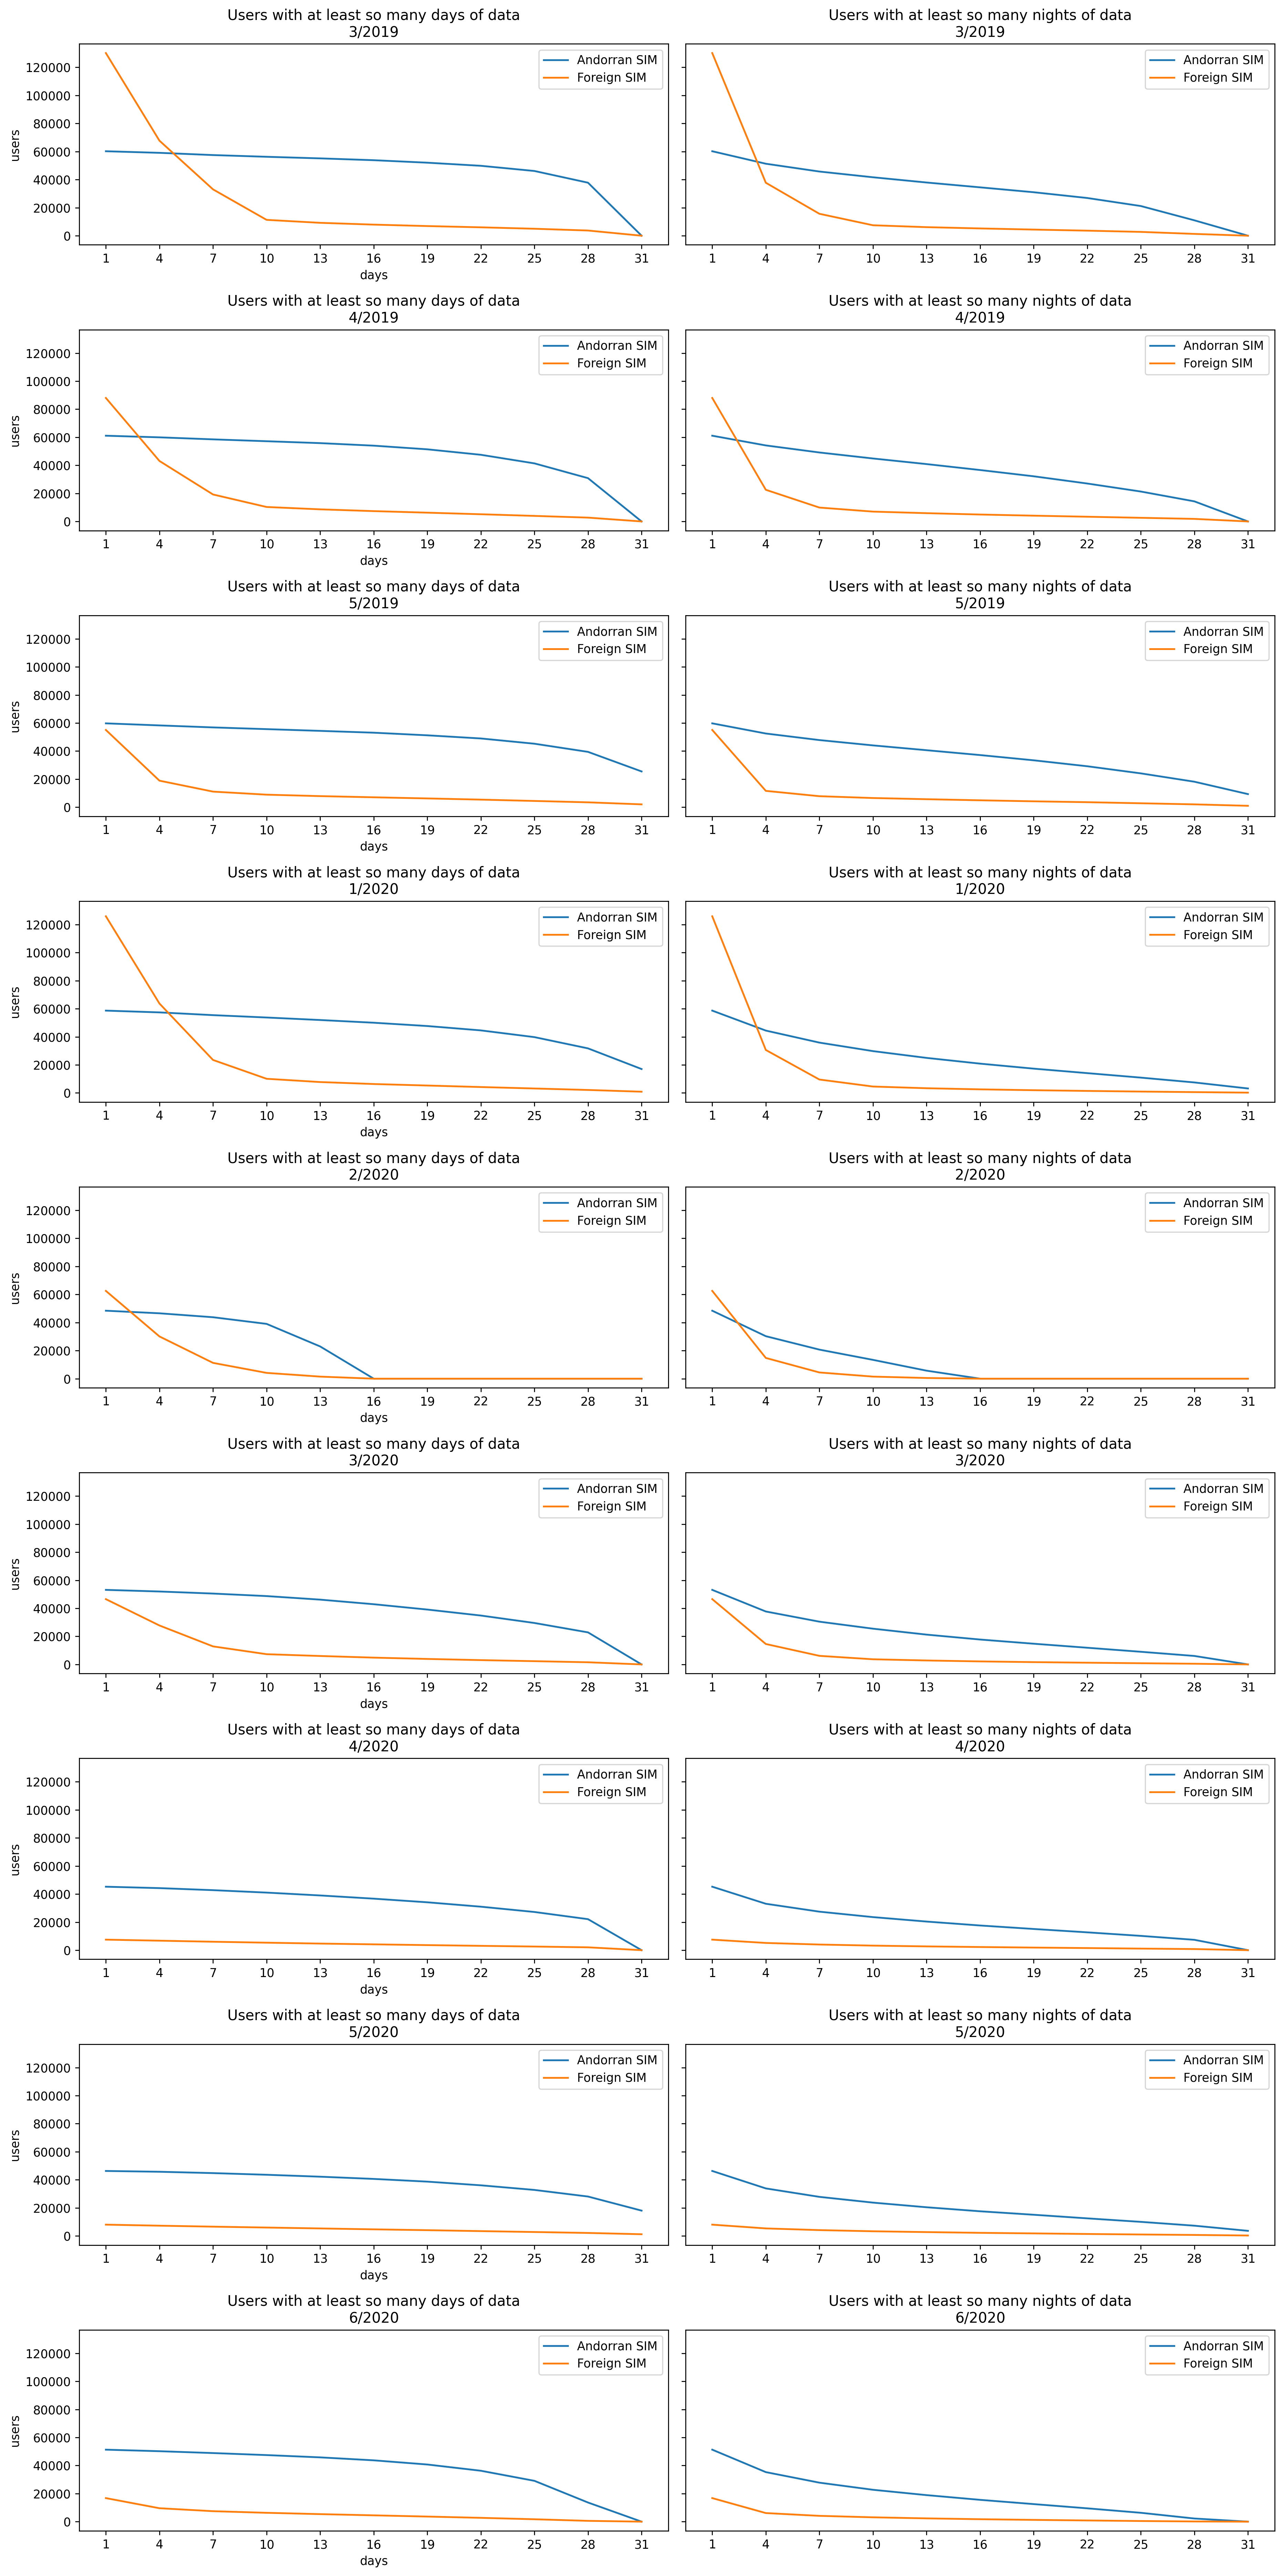

In [11]:
nrows = len(month_data_days)
ncols = 2

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,sharey=True,figsize=(15,15*ncols),dpi=250)

for i, (year,month) in enumerate(months):
    days_df = month_data_days[(year,month)]
    nights_df = month_data_nights[(year,month)]
    days_ax, nights_ax = axes.flat[2*i], axes.flat[2*i+1]
    days_ax.plot(
        days_nights_list,
        days_df[ANDORRAN_SIM],
        label=ANDORRAN_SIM,
    )
    days_ax.plot(
        days_nights_list,
        days_df[FOREIGN_SIM],
        label=FOREIGN_SIM,
    )
    days_ax.set_title('Users with at least so many days of data\n%s/%s' % (month,year))
    days_ax.set_xlabel('days')
    days_ax.set_ylabel('users')
    days_ax.set_xticks(days_nights_list)
    days_ax.legend()
    nights_ax.plot(
        days_nights_list,
        nights_df[ANDORRAN_SIM],
        label=ANDORRAN_SIM,
    )
    nights_ax.plot(
        days_nights_list,
        nights_df[FOREIGN_SIM],
        label=FOREIGN_SIM,
    )
    nights_ax.set_title('Users with at least so many nights of data\n%s/%s' % (month,year))
    nights_ax.set_xticks(days_nights_list)
    nights_ax.legend()
    
plt.tight_layout()

Based  on the above plots (and messing around with the parish population distributions per different parameters below), it looks  like reasonable data frames  can restrict  data to Andorran SIMs with at least D=10  days of data and at least N=4 nights of data.

### Population statistics vs RNC data

#### How does this data match up with known poulation statistics?

Based on the above plots, we'll consider likely Andorran residents as users with at least D=10  days of data and at least N=4 nights of data.

In [12]:
def plot_parish_population(df, ax, title='Population'):
    a_parish_counts = df[df[ANDORRAN_SIM]][PARISH].value_counts()
    a_parish_counts.plot.bar(color='blue',ax=ax,label=ANDORRAN_SIM)
    f_parish_counts = df[~df[ANDORRAN_SIM]][PARISH].value_counts()
    if len(f_parish_counts):
        f_parish_counts.plot.bar(color='orange',ax=ax,label=FOREIGN_SIM,
                             bottom=a_parish_counts.values)  
    ax.set_title(title)
    ax.legend()
    

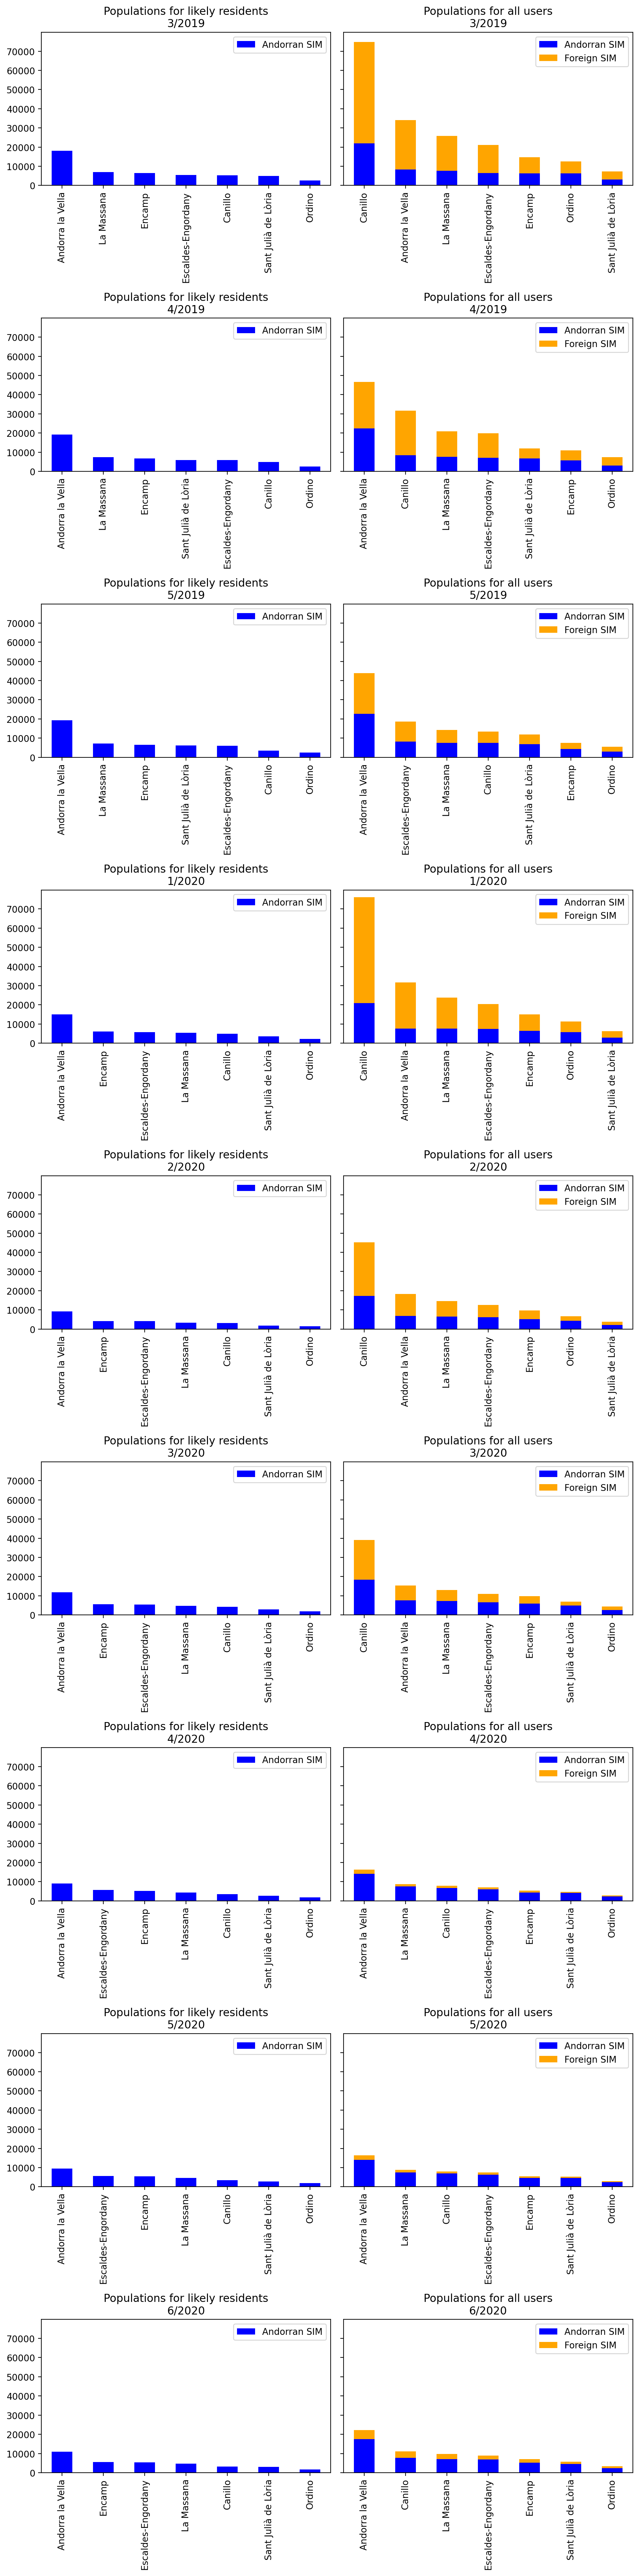

In [13]:
nrows = len(month_data_days)
ncols = 2

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,sharey=True,figsize=(10,20*ncols),dpi=200)

for i, (year,month) in enumerate(months):
    df = months_homes_dfs[(year,month)]
    likely_residents_df = df[(df[ANDORRAN_SIM] & (df[DAYS] >=10) & (df[NIGHTS] >=4))]
    ax1, ax2 = axes.flat[2*i], axes.flat[2*i+1]
    plot_parish_population(likely_residents_df, ax1,
                           title='Populations for likely residents\n%s/%s'%(month,year))
    plot_parish_population(df, ax2, title='Populations for all users\n%s/%s'%(month,year))
    
plt.tight_layout()
plt.show()

## Nationalities

From month to month

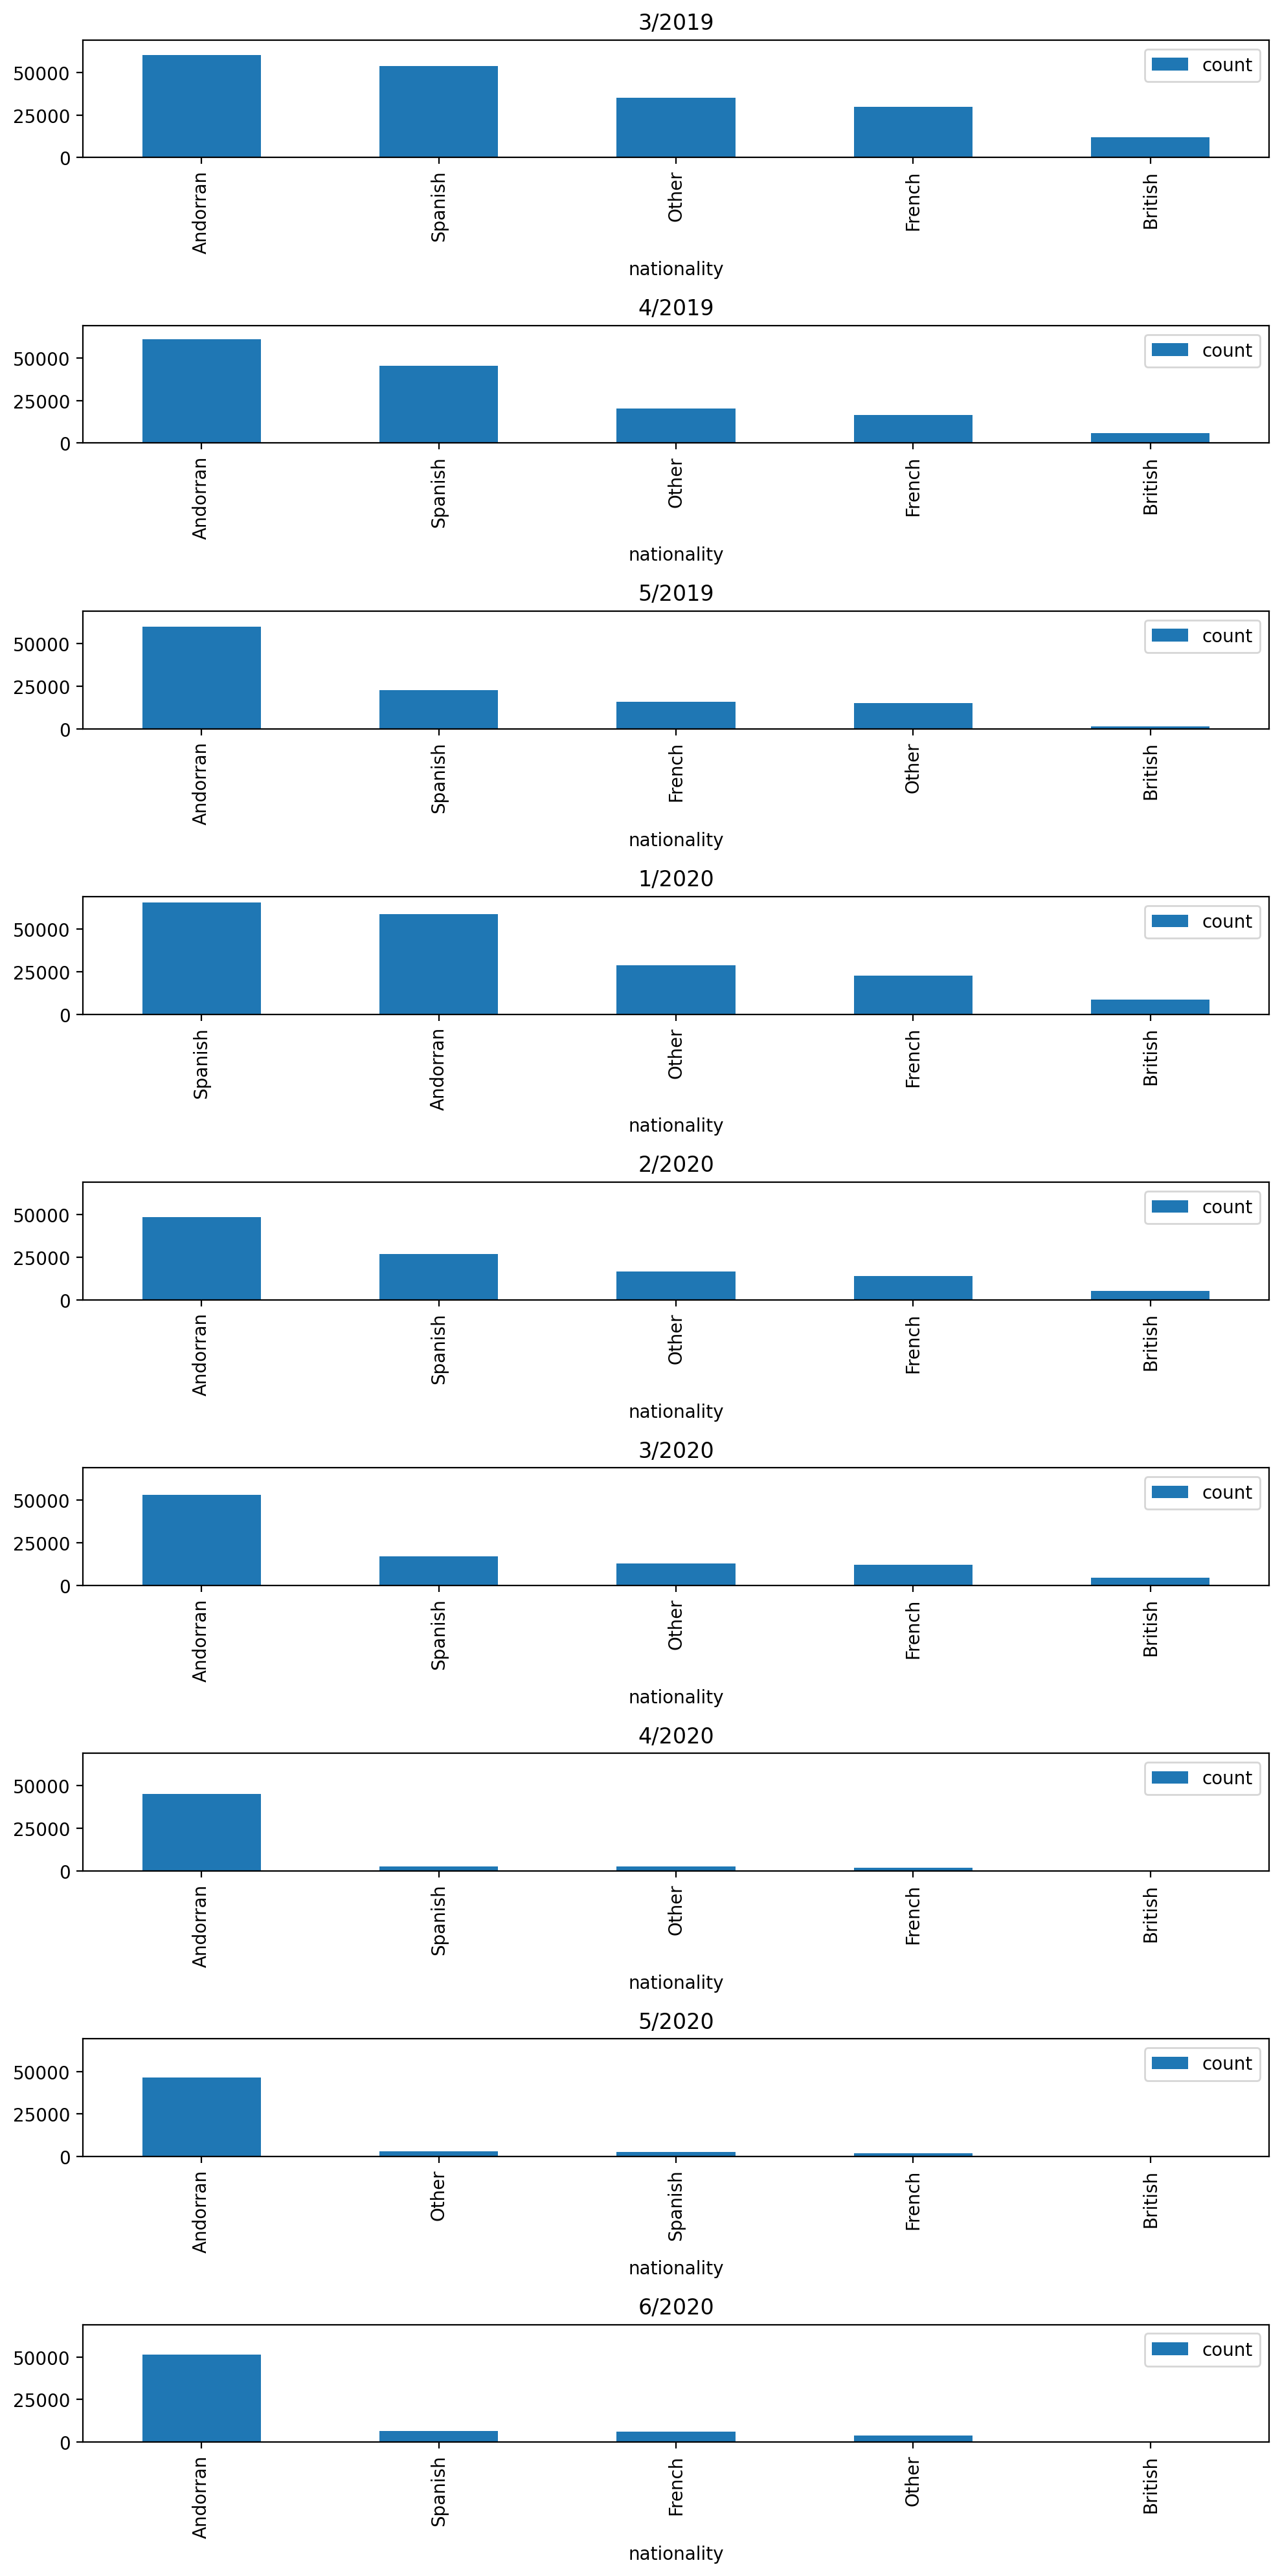

In [14]:
nrows = len(month_data_days)
ncols = 1

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,sharey=True,figsize=(10,20*ncols),dpi=200)

for i, (year,month) in enumerate(months):
    df = months_homes_dfs[(year,month)]
    
    ax = axes.flat[i]
    nationality_counts = df[NATIONALITY].value_counts().rename('count').reset_index().rename(columns={'index':'nationality'})

    nationality_counts.plot.bar(x='nationality',y='count',ax=ax)
    
    ax.set_title('%s/%s' % (month,year))
    
plt.tight_layout()
plt.show()

## When did people leave (or enter) the  country?

Find people who were present in month i (February).
For months (i + 1) onward, show daily number of people  still present.

After collecting the IMSI's, map each IMSI to the last day they were seen. Then plot time series of last days users were present.
- by parish
- by andorran vs foreign SIM


In [15]:
feb_month, feb_year = 2, 2020
users_leaving_df = months_homes_dfs[(feb_year, feb_month)].copy()[[IMSI, ANDORRAN_SIM, PARISH]]
print('%s %s/%s users'%(len(users_leaving_df), feb_month, feb_year))
users_leaving_df.head(3)

111008 2/2020 users


,imsi,Andorran SIM,parish
0,000054e634b0868ae8816f7d5761b7bfb8aea6804296f2...,True,Andorra la Vella
1,0000d28061016e55ea2e5f2c68a2234b641cd8868cd31a...,False,Andorra la Vella
2,0000ec008235b115def70c44ec9931ab1161ee1854e5d9...,True,Andorra la Vella


In [16]:
def daterange(start_datetime, end_datetime):
    for n in range(int((end_datetime - start_datetime).days) + 1):
        yield start_datetime + datetime.timedelta(n)

date_fmt = '%Y-%m-%d'
start_date = '2020-03-01'
end_date = '2020-07-01'

datetimes = [d for d in daterange(datetime.datetime.strptime(start_date, date_fmt), 
                                   datetime.datetime.strptime(end_date, date_fmt))]

In [ ]:
"""
Get the set of people from month i

for each day after start of  month i + 1, show number of those people present in the data.

Do this by Andorran vs foreign SIMs.

make a table:

imsi, parish, Andorran SIM, last day
"""
LAST_DAY = 'last day'

user_imsis = users_leaving_df[IMSI].unique()
imsis_to_last_day = {}



for i,d in enumerate(datetimes):
    date_str = d.strftime(date_fmt)
    print('%s/%s: processing %s' % (i+1, len(datetimes), date_str))
    stays_filepath = get_stays_filepath(d.year, d.month, d.day)
    if not pathlib.Path(stays_filepath).is_file():
        print('skipping %s -- file not found: %s' % (date_str, stays_filepath))
        continue
    df = pd.read_csv(stays_filepath)
    # drop the records from stays outside of Andorra
    df = df[~df[PARISH].isnull()]
    # restrict the data to IMSIS of focus
    df = df[df[IMSI].isin(user_imsis)]
    day_imsis = df[IMSI].unique()
    for imsi in day_imsis:
        imsis_to_last_day[imsi] = d
        
    

In [ ]:
users_leaving_df[LAST_DAY] = users_leaving_df[IMSI].map(imsis_to_last_day)
users_leaving_df.head()

In [77]:
nulls = len(users_leaving_df[users_leaving_df[LAST_DAY].isnull()])
print('dropping %s users with no presence after %s/%s'%(nulls, feb_month,feb_year))
users_leaving_df = users_leaving_df[~users_leaving_df[LAST_DAY].isnull()]
len(users_leaving_df)

dropping 52508 users with no presence after 2/2020


58500

In [98]:
"""
For each day, count people still present.

Make separate counts for andorran vs foreign SIMS

And make separate counts for parishes.

"""

andorran_sims_present=[]
foreign_sims_present=[]

# parish name -> people present
parishes=users_leaving_df[PARISH].unique()
parish_pop_present = {p:[] for p in parishes}

for  i, d in  enumerate(datetimes):
    u_present_df = users_leaving_df[users_leaving_df[LAST_DAY]>=d]
    andorran_sims_present += [len(u_present_df[u_present_df[ANDORRAN_SIM]])]
    foreign_sims_present += [len(u_present_df[~u_present_df[ANDORRAN_SIM]])]
    for p in parishes:
        p_present = len(u_present_df[u_present_df[PARISH]==p])
        parish_pop_present[p]+=[p_present]
    

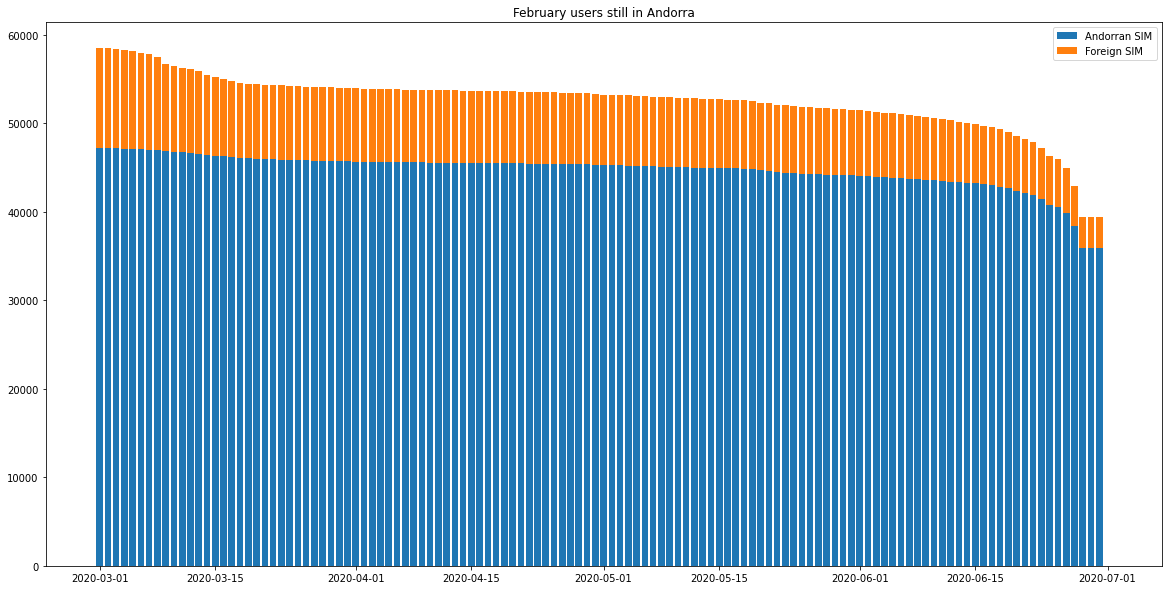

In [100]:
figure, ax = plt.subplots(figsize=(20, 10))

ax.bar(datetimes,andorran_sims_present,label=ANDORRAN_SIM)
ax.bar(datetimes,foreign_sims_present,label=FOREIGN_SIM,bottom=andorran_sims_present)
ax.set_title('February users still in Andorra')
ax.legend()

plt.show()

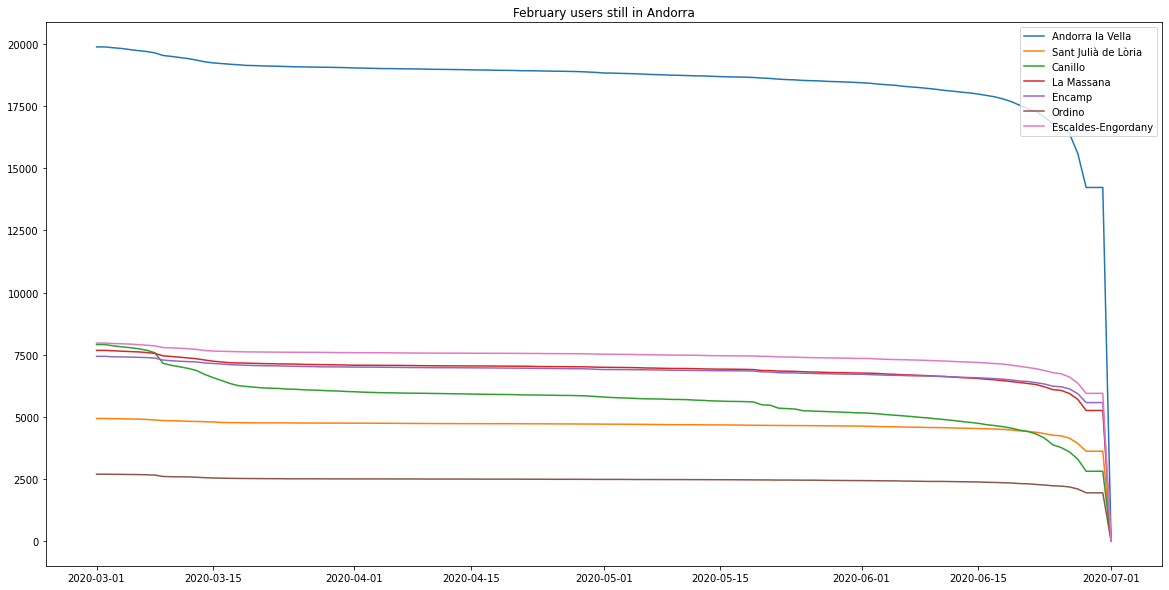

In [103]:
figure, ax = plt.subplots(figsize=(20, 10))

for p, p_pop in parish_pop_present.items():
    ax.plot(datetimes, p_pop, label=p)

ax.set_title('February users still in Andorra')
ax.legend(loc='upper right')

plt.show()